In [2]:
import pandas as pd
import datetime 
from src.waybackmachine_helper import to_wb_timestamp, get_closest_snapshot_url, get_wb_timestamp, get_actual_url, get_wb_available_url
from src.vnexpress_helper import get_articles_links, get_article_id, get_thumbnail_url, get_ext
from tqdm import tqdm
import argparse

import os
from bs4 import BeautifulSoup

import src.multithread_craw as multithread_craw

In [3]:
web_url = "https://vnexpress.net/giai-tri"

# 1. Check if wayback machine has snapshots of that website on a list of dates

In [4]:
# base = datetime.datetime.today()

# today
base = datetime.datetime(2023, 11, 21)

# 2 years back
numofdays = 2*365
# numdays = 150

# every 5 days
every = 5

date_list = [base - datetime.timedelta(days=x) for x in range(0,numofdays,every)]
timestamps = [to_wb_timestamp(d) for d in date_list]

In [5]:
wb_urls = pd.DataFrame()
wb_urls["wb_timestamp"] = timestamps
wb_urls["wb_url"] = wb_urls["wb_timestamp"].apply(lambda t: get_wb_available_url(web_url=web_url,timestamp=t))

wb_urls.to_json("./temp/wayback_machine_available_urls.jsonl", orient="records", lines=True)
wb_urls

,wb_timestamp,wb_url
0,20231121,https://archive.org/wayback/available?url=http...
1,20231116,https://archive.org/wayback/available?url=http...
2,20231111,https://archive.org/wayback/available?url=http...
3,20231106,https://archive.org/wayback/available?url=http...
4,20231101,https://archive.org/wayback/available?url=http...
...,...,...
141,20211216,https://archive.org/wayback/available?url=http...
142,20211211,https://archive.org/wayback/available?url=http...
143,20211206,https://archive.org/wayback/available?url=http...
144,20211201,https://archive.org/wayback/available?url=http...


In [8]:
args = argparse.Namespace(
    urls_list="./temp/wayback_machine_available_urls.jsonl",
    nof_threads=1,
    output_path="./outputs/wayback_machine_available_raw.jsonl",

    save_every=20,
    tmp_path="./temp/wayback_machine_available_tmp.jsonl",
    # resume=True,
    resume=False,
    retry=3,

    testing=False,
    download_file=False,
    print_error=False
)
multithread_craw.main(args)


resuming from  ./temp/wayback_machine_available_tmp.jsonl


  0%|          | 0/78 [00:00<?, ?it/s]

In [13]:
content = pd.read_json("./outputs/wayback_machine_available_raw.jsonl", orient="records", lines=True)
def get_url(c):
    failed, url = get_closest_snapshot_url(c)
    if failed:
        return None
    return url

content["content"] = content["content"].apply(get_url)

content.drop_duplicates(subset="content", inplace=True)
content

,wb_timestamp,wb_url,content
0,20231121,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20231113140000/http...
3,20231106,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20231101113119/http...
5,20231027,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20231028092735/http...
6,20231022,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20231023053821/http...
7,20231017,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20231018062036/http...
...,...,...,...
141,20211216,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20211217012023/http...
142,20211211,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20211212133627/http...
143,20211206,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20211207050258/http...
144,20211201,https://archive.org/wayback/available?url=http...,http://web.archive.org/web/20211202052837/http...


# 2. request snapshots of that webpage from wayback machine

In [15]:
front_page_snapshot_urls = pd.DataFrame()

front_page_snapshot_urls["wb_timestamp"] = content["content"].apply(get_wb_timestamp)
front_page_snapshot_urls["wb_url"] = content["content"]
front_page_snapshot_urls.drop_duplicates(inplace=True)
front_page_snapshot_urls.to_json("./temp/front_page_snapshot_urls.jsonl", orient="records", lines=True)
front_page_snapshot_urls

,wb_timestamp,wb_url
0,20231113140000,http://web.archive.org/web/20231113140000/http...
3,20231101113119,http://web.archive.org/web/20231101113119/http...
5,20231028092735,http://web.archive.org/web/20231028092735/http...
6,20231023053821,http://web.archive.org/web/20231023053821/http...
7,20231018062036,http://web.archive.org/web/20231018062036/http...
...,...,...
141,20211217012023,http://web.archive.org/web/20211217012023/http...
142,20211212133627,http://web.archive.org/web/20211212133627/http...
143,20211207050258,http://web.archive.org/web/20211207050258/http...
144,20211202052837,http://web.archive.org/web/20211202052837/http...


In [3]:
args = argparse.Namespace(
    urls_list="./temp/front_page_snapshot_urls.jsonl",
    nof_threads=1,
    output_path="./outputs/front_page_snapshot_raw.jsonl",

    save_every=10,
    tmp_path="./temp/front_page_snapshot_raw.jsonl",
    # resume=False,
    resume=True,
    retry=3,
    testing=False,
    download_file=False,
    print_error=False
)
multithread_craw.main(args)


resuming from  ./temp/front_page_snapshot_raw.jsonl


0it [00:00, ?it/s]

# 3. extract articles urls from those snapshots

In [4]:
content = pd.read_json("./outputs/front_page_snapshot_raw.jsonl", orient="records", lines=True)
content

,wb_timestamp,wb_url,content
0,20231113140000,http://web.archive.org/web/20231113140000/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
1,20231101113119,http://web.archive.org/web/20231101113119/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
2,20231028092735,http://web.archive.org/web/20231028092735/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
3,20231023053821,http://web.archive.org/web/20231023053821/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
4,20231018062036,http://web.archive.org/web/20231018062036/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
...,...,...,...
135,20211217012023,http://web.archive.org/web/20211217012023/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
136,20211212133627,http://web.archive.org/web/20211212133627/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
137,20211207050258,http://web.archive.org/web/20211207050258/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
138,20211202052837,http://web.archive.org/web/20211202052837/http...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."


In [7]:
articles_links = pd.DataFrame(columns=["article_id", "article_url"])

for r, (_, _, text) in content.iterrows():
    soup = BeautifulSoup(text, "html.parser")
    links = get_articles_links(soup)
    if len(links) == 0:
        print("failed! ", r)
        continue

    for l in links:
        if l.endswith("-tong-thuat.html"):
            article_id = get_article_id(l.replace("-tong-thuat.html", ".html"))
        else:
            article_id = get_article_id(l)

        article_url = get_actual_url(l)


        if article_id not in articles_links["article_id"].values:
            articles_links.loc[len(articles_links.index)] = [article_id, article_url]
articles_links.to_json("./temp/articles_urls.jsonl", orient="records", lines=True)
articles_links

,article_id,article_url
0,4675083,https://vnexpress.net/trang-phap-toi-khong-ham...
1,4676469,https://vnexpress.net/kenny-g-toi-xuc-dong-voi...
2,4672432,https://vnexpress.net/frances-farmer-thien-tha...
3,4676065,https://vnexpress.net/dung-mao-ly-lien-kiet-tu...
4,4676457,https://vnexpress.net/tuan-thoi-trang-quoc-te-...
...,...,...
6215,4394012,https://vnexpress.net/ha-ho-kim-ly-tai-hien-mv...
6216,4393924,https://vnexpress.net/my-nhan-an-do-tai-miss-w...
6217,4393878,https://vnexpress.net/thi-sang-tac-van-hoc-de-...
6218,4393803,https://vnexpress.net/do-thi-ha-duoc-du-doan-v...


# 4. craw those articles

In [8]:
args = argparse.Namespace(
    urls_list="./temp/articles_urls.jsonl",
    nof_threads=8,
    output_path="./outputs/articles_raw.jsonl",
    save_every=200,
    tmp_path="./temp/articles_raw.jsonl",
    # resume=False,
    resume=True,
    retry=3,
    testing=False,
    download_file=False,
    print_error=False
)
multithread_craw.main(args)

resuming from  ./temp/articles_raw.jsonl


  0%|          | 0/156 [00:00<?, ?it/s]

In [2]:
content = pd.read_json("./outputs/articles_raw.jsonl", orient="records", lines=True)
content

,article_id,article_url,content
0,4675083,https://vnexpress.net/trang-phap-toi-khong-ham...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
1,4676469,https://vnexpress.net/kenny-g-toi-xuc-dong-voi...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
2,4672432,https://vnexpress.net/frances-farmer-thien-tha...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
3,4676065,https://vnexpress.net/dung-mao-ly-lien-kiet-tu...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
4,4676457,https://vnexpress.net/tuan-thoi-trang-quoc-te-...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
...,...,...,...
6215,4394012,https://vnexpress.net/ha-ho-kim-ly-tai-hien-mv...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
6216,4393924,https://vnexpress.net/my-nhan-an-do-tai-miss-w...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
6217,4393878,https://vnexpress.net/thi-sang-tac-van-hoc-de-...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
6218,4393803,https://vnexpress.net/do-thi-ha-duoc-du-doan-v...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."


# 5. extract thumbnail urls from those articles

In [12]:
thumbnail_links = pd.DataFrame(columns=["article_id", "thumbnail_url"])

for r, (article_id, _, text) in content.iterrows():
    soup = BeautifulSoup(text, "html.parser")
    link = get_thumbnail_url(soup)

    if article_id not in thumbnail_links["article_id"].values:
        thumbnail_links.loc[len(thumbnail_links.index)] = [article_id, link]

def get_save_path(r):
    return os.path.join("./outputs", "thumbnails", str(r["article_id"]) + get_ext(r["thumbnail_url"]))

thumbnail_links["save_path"] = thumbnail_links.apply(get_save_path, axis=1)

thumbnail_links.to_json("./temp/thumbnails_urls.jsonl", orient="records", lines=True)

Error: HTTPSConnectionPool(host='vnexpress.net', port=443): Read timed out. (read timeout=None)


In [13]:
thumbnail_links

,article_id,thumbnail_url,save_path
0,4675083,https://vcdn1-giaitri.vnecdn.net/2023/11/13/tr...,./outputs/thumbnails/4675083.jpg
1,4676469,https://vcdn1-giaitri.vnecdn.net/2023/11/13/ke...,./outputs/thumbnails/4676469.jpg
2,4672432,https://vcdn1-giaitri.vnecdn.net/2023/11/10/fr...,./outputs/thumbnails/4672432.jpg
3,4676065,https://vcdn1-giaitri.vnecdn.net/2023/11/12/to...,./outputs/thumbnails/4676065.jpg
4,4676457,https://vcdn1-giaitri.vnecdn.net/2023/11/13/tu...,./outputs/thumbnails/4676457.jpg
...,...,...,...
6215,4394012,https://vcdn1-giaitri.vnecdn.net/2021/11/24/HO...,./outputs/thumbnails/4394012.jpg
6216,4393924,https://vcdn1-giaitri.vnecdn.net/2021/11/24/to...,./outputs/thumbnails/4393924.jpg
6217,4393878,https://vcdn1-giaitri.vnecdn.net/2021/11/24/on...,./outputs/thumbnails/4393878.jpg
6218,4393803,https://vcdn1-giaitri.vnecdn.net/2021/11/24/do...,./outputs/thumbnails/4393803.jpg


# 6. download those thumbnails 

In [5]:
args = argparse.Namespace(
    urls_list="./temp/thumbnails_urls.jsonl",
    nof_threads=8,
    output_path="./outputs/thumbnails_path.jsonl",
    save_every=20,
    tmp_path="./temp/thumbnails_path.jsonl",
    resume=True,
    retry=3,
    testing=False,
    download_file=True,
    print_error=True
)
multithread_craw.main(args)


resuming from  ./temp/thumbnails_path.jsonl


  0%|          | 0/1 [00:00<?, ?it/s]

Error: HTTP Error 401: Unauthorized


  0%|          | 0/1 [00:00<?, ?it/s]

Error: HTTP Error 401: Unauthorized


  0%|          | 0/1 [00:00<?, ?it/s]

Error: HTTP Error 401: Unauthorized


  0%|          | 0/1 [00:00<?, ?it/s]

Error: HTTP Error 401: Unauthorized


In [ ]:
content = pd.read_json("./outputs/thumbnails_path.jsonl", orient="records", lines=True)
content

,article_id,thumbnail_url,save_path
0,4675083,https://vcdn1-giaitri.vnecdn.net/2023/11/13/tr...,./outputs/thumbnails/4675083.jpg
1,4676469,https://vcdn1-giaitri.vnecdn.net/2023/11/13/ke...,./outputs/thumbnails/4676469.jpg
2,4672432,https://vcdn1-giaitri.vnecdn.net/2023/11/10/fr...,./outputs/thumbnails/4672432.jpg
3,4676065,https://vcdn1-giaitri.vnecdn.net/2023/11/12/to...,./outputs/thumbnails/4676065.jpg
4,4676457,https://vcdn1-giaitri.vnecdn.net/2023/11/13/tu...,./outputs/thumbnails/4676457.jpg
...,...,...,...
6214,4394012,https://vcdn1-giaitri.vnecdn.net/2021/11/24/HO...,./outputs/thumbnails/4394012.jpg
6215,4393924,https://vcdn1-giaitri.vnecdn.net/2021/11/24/to...,./outputs/thumbnails/4393924.jpg
6216,4393878,https://vcdn1-giaitri.vnecdn.net/2021/11/24/on...,./outputs/thumbnails/4393878.jpg
6217,4393803,https://vcdn1-giaitri.vnecdn.net/2021/11/24/do...,./outputs/thumbnails/4393803.jpg


https://vcdn1-giaitri.vnecdn.net/2023/10/02/ho-ngoc-ha-1-jpg-1696217307-9557-1696217511.jpg?w=1200&h=0&q=100&dpr=1&fit=crop&s=6wJPMQA44IIWWEhIBzYWQA


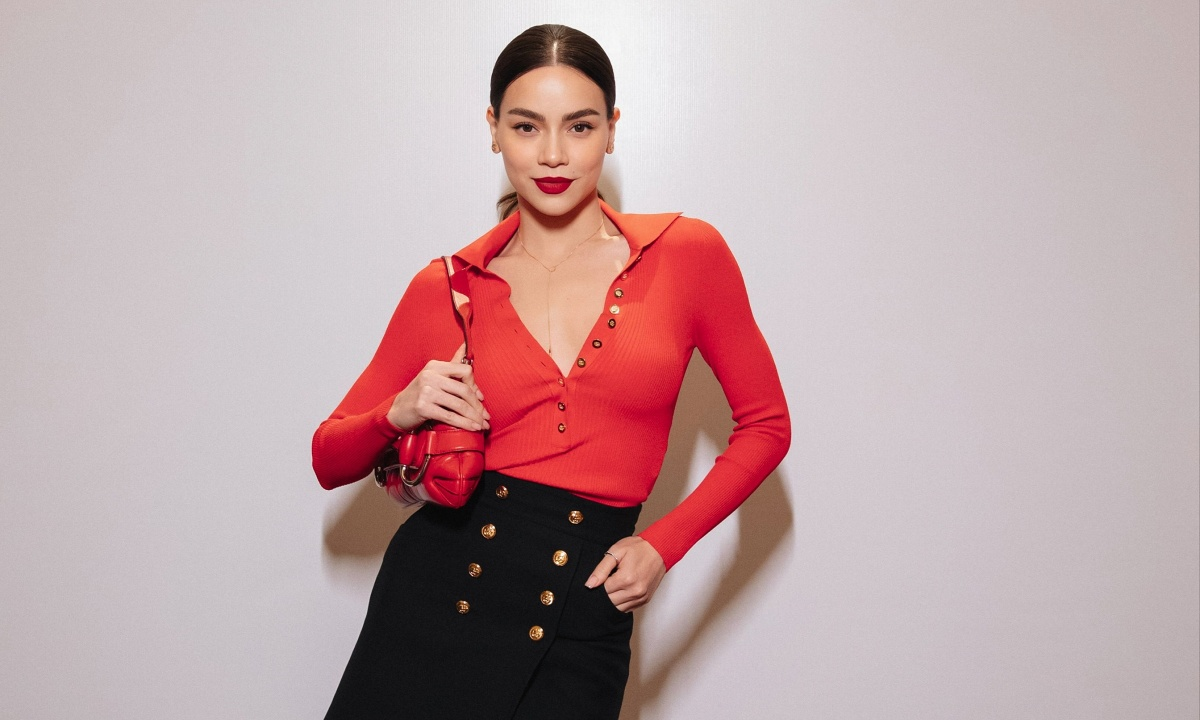

In [8]:
from IPython.display import Image
idx = 324

re = content.loc[idx]

print(re["thumbnail_url"])

Image(filename=re["save_path"])

In [12]:
print(content.loc[6000].article_url)

https://vnexpress.net/dien-vien-cung-tam-ke-2-ket-hon-lan-hai-4403860.html


In [12]:
content = pd.read_json("./outputs/articles_raw.jsonl", orient="records", lines=True)
content

,article_id,article_url,content
0,4675083,https://vnexpress.net/trang-phap-toi-khong-ham...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
1,4676469,https://vnexpress.net/kenny-g-toi-xuc-dong-voi...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
2,4672432,https://vnexpress.net/frances-farmer-thien-tha...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
3,4676065,https://vnexpress.net/dung-mao-ly-lien-kiet-tu...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
4,4676457,https://vnexpress.net/tuan-thoi-trang-quoc-te-...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
...,...,...,...
6215,4394012,https://vnexpress.net/ha-ho-kim-ly-tai-hien-mv...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
6216,4393924,https://vnexpress.net/my-nhan-an-do-tai-miss-w...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
6217,4393878,https://vnexpress.net/thi-sang-tac-van-hoc-de-...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."
6218,4393803,https://vnexpress.net/do-thi-ha-duoc-du-doan-v...,"<!DOCTYPE html>\n<html lang=""vi"" xmlns=""http:/..."


In [3]:
from bs4 import BeautifulSoup, NavigableString, Tag
from collections import OrderedDict

def get_text_from_tag(tag):
    if isinstance(tag, NavigableString):
        return tag
                    
    # else if isinstance(tag, Tag):
    return tag.text;

def extract_content(soup):
    """
    Extract title, description and paragraphs from url
    @param soup (str): url to crawl
    @return title (str)
    @return description (generator)
    @return paragraphs (generator)
    """

    title = soup.find("h1", class_="title-detail") 
    if title == None:
        return None, None, None
    title = title.text

    # some sport news have location-stamp child tag inside description tag
    description = (get_text_from_tag(p) for p in soup.find("p", class_="description").contents)
    paragraphs = (get_text_from_tag(p) for p in soup.find_all("p", class_="Normal"))

    return title, description, paragraphs

def get_text(raw_html):
    soup = BeautifulSoup(raw_html, "html.parser")
    
    title, description, paragraphs = extract_content(soup)

    if not title:
        return None

    context = [title] + [s for s in description] + [s for s in paragraphs]

    context = [s + "." if not s.strip().endswith(".") else s for s in context]

    return " ".join(context)    


In [13]:
articles_text = content
articles_text["content"] = articles_text["content"].apply(get_text)
articles_text["content"] = articles_text["content"].apply(lambda t: t + "^" if t is not null else "^")

articles_text = articles_text.rename(columns={
    "article_id":"id",
    "content":"contents"
})

NameError: name 'null' is not defined

In [10]:
articles_text["content"] is Nu  

False

In [6]:
articles_text

,article_id,article_url,content
0,4675083,https://vnexpress.net/trang-phap-toi-khong-ham...,Trang Pháp: 'Tôi không ham danh vọng' . Trang ...
1,4676469,https://vnexpress.net/kenny-g-toi-xuc-dong-voi...,Kenny G xúc động với tình cảm fan Việt . Kenny...
2,4672432,https://vnexpress.net/frances-farmer-thien-tha...,Frances Farmer - 'thiên thần sa ngã' của Holly...
3,4676065,https://vnexpress.net/dung-mao-ly-lien-kiet-tu...,Dung mạo Lý Liên Kiệt từ niên thiếu tới tuổi 6...
4,4676457,https://vnexpress.net/tuan-thoi-trang-quoc-te-...,Tuần thời trang Quốc tế Việt Nam tôn vinh truy...
...,...,...,...
6215,4394012,https://vnexpress.net/ha-ho-kim-ly-tai-hien-mv...,Hà Hồ - Kim Lý tái hiện MV 'Cả một trời thương...
6216,4393924,https://vnexpress.net/my-nhan-an-do-tai-miss-w...,Mỹ nhân Ấn Độ tại Miss World 2021 . Manasa Var...
6217,4393878,https://vnexpress.net/thi-sang-tac-van-hoc-de-...,Thi sáng tác văn học đề tài công nhân . Cuộc t...
6218,4393803,https://vnexpress.net/do-thi-ha-duoc-du-doan-v...,Đỗ Thị Hà được dự đoán vào top 20 Miss World ....


In [ ]:
articles_text.to_json("./outputs/articles_text.jsonl", orient="records", lines=True)